In [43]:
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
from utils.prep import *
import matplotlib.pyplot as plt

class SWARM:
    def __init__(self, gray, D=4, L=0, U=255,
                W_MIN=0.9, W_MAX=0.3, C1=2., C2=2., 
                POP=5, POP_MIN=5, POP_MAX=40, K=3, G=1000, return_hist=False):
        self.gray = gray.reshape(-1)
        I = np.arange(256)
        hist, _ = np.histogram(gray, bins=np.arange(256+1))
        self.cumsum_n = np.cumsum(hist)
        self.cumsum_ip = np.cumsum(I * hist)

        self.D = D
        self.L = L
        self.U = U
        self.W_MIN = W_MIN
        self.W_MAX = W_MAX
        self.C1 = C1
        self.C2 = C2
        self.POP_MIN = POP_MIN
        self.POP_MAX = POP_MAX
        self.K_MAX = K
        self.G = G
        self.V_MAX = 0.2 * (U - L)

        self.w = W_MAX
        self.k = 0
        self.v = np.random.uniform(-1, 1, (POP, D)) * self.V_MAX
        self.x = L + np.random.uniform(size=(POP, D)) * (U - L)
        self.fitness = np.array([self.objective(e) for e in self.x])
        self.best_fitness = self.fitness.max()
        self.p_best = self.x
        self.g_best = self.x[self.fitness.argmax()]
        self.return_hist = return_hist

        self.hist_x = []
        self.hist_fitness = []


    def run(self):
        for g in range(self.G):
            # adaptive inertia
            cond1 = (self.k <= -self.K_MAX)
            cond2 = (self.k >= self.K_MAX)
            pop = len(self.x)
            if cond1:
                if self.w > self.W_MIN:
                    self.w -= 0.1
                    self.k = 0
                # adaptive pop
                if pop >= self.POP_MAX:
                    self.del_pop()
                else:
                    self.add_pop()
            elif cond2:
                if self.w < self.W_MAX:
                    self.w += 0.1
                    self.k = 0
                # adaptive pop
                if pop <= self.POP_MIN:
                    pass
                else:
                    self.del_pop()

            # update p_best / g_best
            new_fitness = np.array([self.objective(e) for e in self.x])
            arg_best = new_fitness.argmax()
            if new_fitness[arg_best] > self.best_fitness:
                self.best_fitness = new_fitness[arg_best]
                self.g_best = self.x[arg_best]
                # update k
                if self.k > 0:
                    self.k += 1
                else:
                    self.k = 1
            else:
                # update k
                if self.k > 0:
                    self.k = -1
                else:
                    self.k -= 1
            is_fitter = new_fitness > self.fitness
            self.p_best[is_fitter] = self.x[is_fitter]
            # update fitness
            self.fitness = new_fitness
            # update v, x
            self.v = self.w * self.v \
                + self.C1 * np.random.uniform() * (self.p_best - self.x) \
                + self.C2 * np.random.uniform() * (self.g_best - self.x)
            self.x = self.x + self.v
            self.x = np.clip(self.x, a_min=self.L, a_max=self.U)
            self.v = np.clip(self.v, a_min=-self.V_MAX, a_max=self.V_MAX)
            
            if self.return_hist:
                self.hist_x.append(self.x.astype(np.uint8))
                self.hist_fitness.append(self.fitness)

    def add_pop(self):
        d = np.random.randint(0, self.D-1)
        lamb = np.random.uniform(size=(1, self.D))
        # init new particle
        np_x = self.g_best.reshape(1, -1) 
        np_v = np.random.uniform(-1, 1, (1, self.D)) * self.V_MAX
        np_p_best = self.L + lamb * (self.U - self.L)
        np_p_best[0, d] = self.g_best[d]
        np_fitness = self.objective(np_x)
        # add corresponding states
        self.p_best = np.append(self.p_best, np_p_best, 0)
        self.v = np.append(self.v, np_v, 0)
        self.x = np.append(self.x, np_x, 0)
        self.fitness = np.append(self.fitness, np_fitness)

    def del_pop(self):
        # random particle to remove
        idx = np.random.randint(0, len(self.x) - 1)
        # remove corresponding states
        self.p_best = np.delete(self.p_best, idx, 0)
        self.v = np.delete(self.v, idx, 0)
        self.x = np.delete(self.x, idx, 0)
        self.fitness = np.delete(self.fitness, idx, 0)
        
    def objective(self, ths):
        ths = np.sort(np.append(ths, 256)).astype(np.uint8)
        w = np.zeros(len(ths) + 1)
        u = np.zeros(len(ths) + 1)

        curr_cumsum_n = 0
        curr_cumsum_ip = 0
        for i, th in enumerate(ths-1):
            cum_n = self.cumsum_n[th]
            cum_ip = self.cumsum_ip[th]
            w[i] = cum_n - curr_cumsum_n
            u[i] = (cum_ip - curr_cumsum_ip)
            curr_cumsum_n = cum_n
            curr_cumsum_ip = cum_ip
        ut = (u / w.sum()).sum()
        return (w / w.sum() * (u / (w + 1e-8) - ut) ** 2).sum()
    
    def get_best(self):
        return np.sort(self.g_best.astype(np.uint8)).tolist()

    def get_var(self):
        return self.objective(self.g_best)
    
    def get_hist(self):
        return self.hist_x, self.hist_fitness

def read_image(path, scale=1/4):
    try:
        if Path(path).suffix.lower() == ".heic":
            img = open_heif(path, convert_hdr_to_8bit=True)
        else:
            img = Image.open(path)
        rgb = np.asarray(img)
        H, W = rgb.shape[:-1]
        new_H = int(H * scale)
        new_W = int(W * scale)
    except:
        print(path)
        raise
    return cv2.resize(rgb, (new_W, new_H))

def get_dab(img, level=3):
    # gray macenko
    normalizer = NumpyMacenkoNormalizer()
    normalizer.fit(img)
    Inorm, H, DAB = normalizer.normalize(img)
    gray = cv2.cvtColor(DAB, cv2.COLOR_RGB2GRAY)
    # mth
    swarm = SWARM(gray, D=level)
    swarm.run()
    mth = swarm.get_best()
    # get q image
    th1 = 0
    img_list = []
    for i, th in enumerate(mth + [256]):
        th2 = th
        mask = (th1 <= gray) & (gray < th2)
        img_list.append(mask.T)
        th1 = th
    q_img = np.array(img_list[:3]).T * 255
    return gray, q_img

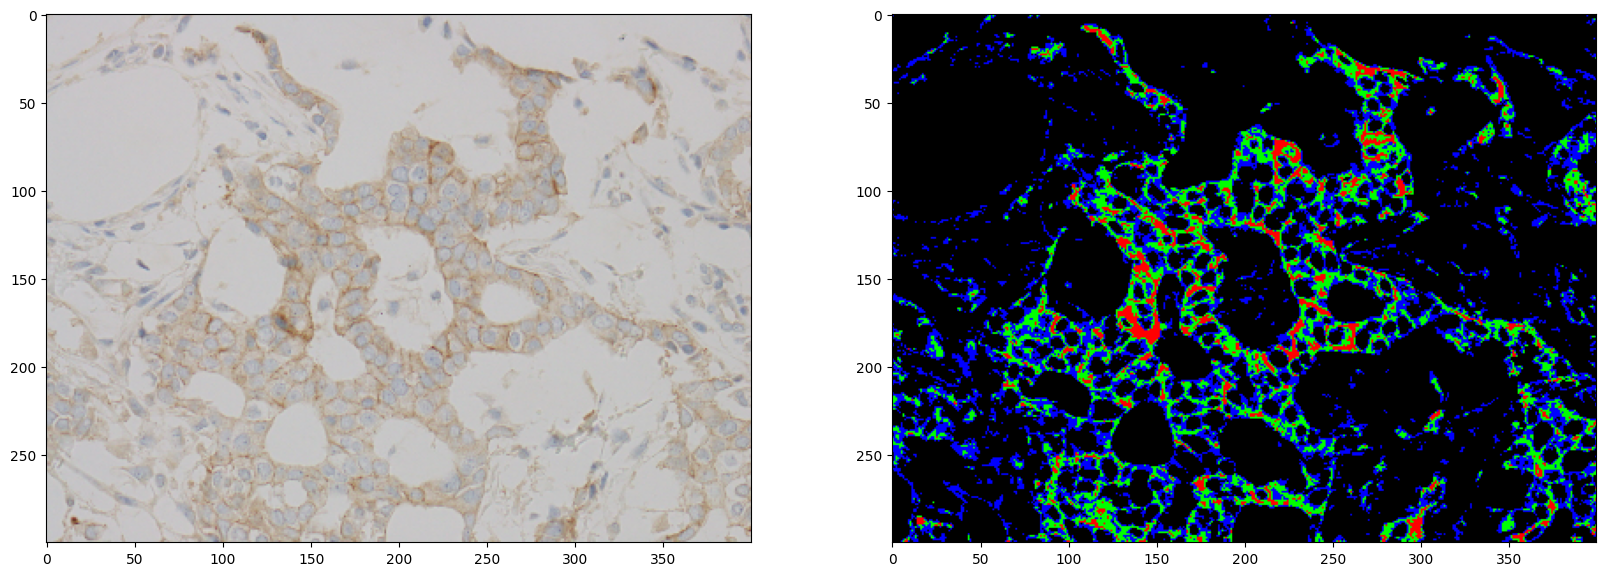

In [44]:
path = "/home/surayuth/her2/Data_Chula/HER2 2+ DISH+ case 07/IMG_8718.HEIC"
img = read_image(path, scale=1/4)
dab, q_img = get_dab(img, level=4)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.imshow(img)
ax2.imshow(q_img)